# Juego de Tronos (Libro 1): QA + Imagen (Notebook independiente)

Este notebook es **autocontenido**: no depende de archivos `.py` externos.
Modelos:
- QA/Planner: `Qwen/Qwen3-30B-A3B-Thinking-2507-FP8`
- Imagen: `stabilityai/stable-diffusion-3.5-large`


In [1]:
!pip -q install -U "pandas==2.2.2"
!pip -q install -U pyarrow beautifulsoup4 lxml faiss-cpu sentence-transformers transformers accelerate diffusers safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 47.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 113.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 52.5 MB/s eta 0:00:0000:010:01m


In [2]:
from google.colab import drive
drive.mount('/content/drive')

EPUB_PATH = '/content/drive/MyDrive/juego_de_tronos.epub'


Mounted at /content/drive


In [ ]:
from huggingface_hub import login
login("")


In [3]:
import json
import os
import re
import zipfile
from typing import Optional

import faiss
import numpy as np
import pandas as pd
import torch
from bs4 import BeautifulSoup
from diffusers import StableDiffusion3Pipeline
from sentence_transformers import SentenceTransformer, CrossEncoder
from transformers import AutoTokenizer, AutoModelForCausalLM

QWEN_MODEL_ID = 'Qwen/Qwen3-30B-A3B-Thinking-2507'
EMBED_MODEL_ID = 'BAAI/bge-m3'
RERANKER_MODEL_ID = 'BAAI/bge-reranker-large'
SD3_MODEL_ID = 'stabilityai/stable-diffusion-3-medium-diffusers'


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [4]:
def clean_text(text: str) -> str:
    text = re.sub(r"\r\n?", "\n", text)
    text = re.sub(r"\n\s*\n+", "\n\n", text)
    text = re.sub(r"[ \t]+", " ", text)
    return text.strip()


def extract_title_and_pov(text: str) -> tuple[Optional[str], Optional[str]]:
    lines = [ln.strip() for ln in text.split("\n") if ln.strip()]
    for line in lines[:20]:
        if re.match(r"^[A-ZÁÉÍÓÚÑÜ]+.*\(\d+\)$", line):
            return line, line.split("(")[0].strip()
    return None, None


def list_xhtml_text_files(zf: zipfile.ZipFile) -> list[str]:
    candidates = [f for f in zf.namelist() if f.lower().endswith((".xhtml", ".html"))]
    preferred = [f for f in candidates if '/text/' in f.lower() or '/texto/' in f.lower()]
    return sorted(preferred if preferred else candidates)


def extract_chapters(epub_path: str) -> pd.DataFrame:
    if not os.path.exists(epub_path):
        raise FileNotFoundError(f'No existe EPUB_PATH: {epub_path}')

    chapters = []
    with zipfile.ZipFile(epub_path, 'r') as zf:
        for file_name in list_xhtml_text_files(zf):
            soup = BeautifulSoup(zf.read(file_name), 'lxml')
            text = clean_text(soup.get_text('\n'))
            if len(text) < 800:
                continue
            title, pov = extract_title_and_pov(text)
            chapters.append({
                'chapter_id': len(chapters),
                'epub_file': file_name,
                'title': title,
                'pov': pov,
                'text': text,
                'n_chars': len(text),
            })
    return pd.DataFrame(chapters)


def chunk_text(text: str, chunk_size: int = 4500, overlap: int = 750):
    if chunk_size <= overlap:
        raise ValueError('chunk_size debe ser mayor que overlap')
    start = 0
    chunks = []
    while start < len(text):
        end = min(start + chunk_size, len(text))
        piece = text[start:end].strip()
        if piece:
            chunks.append((start, end, piece))
        start += (chunk_size - overlap)
    return chunks


def build_chunks(chapters_df: pd.DataFrame, chunk_size: int = 4500, overlap: int = 750) -> pd.DataFrame:
    rows = []
    for _, ch in chapters_df.iterrows():
        for i, (s, e, t) in enumerate(chunk_text(ch['text'], chunk_size, overlap)):
            rows.append({
                'chunk_id': f"{int(ch['chapter_id'])}_{i}",
                'chapter_id': int(ch['chapter_id']),
                'epub_file': ch['epub_file'],
                'title': ch['title'],
                'pov': ch['pov'],
                'start_char': s,
                'end_char': e,
                'text': t,
                'n_chars': len(t),
            })
    return pd.DataFrame(rows)


In [5]:
chapters_df = extract_chapters(EPUB_PATH)
chunks_df = build_chunks(chapters_df)

chapters_df.to_parquet('chapters.parquet', index=False)
chunks_df.to_parquet('chunks.parquet', index=False)

print('Capítulos:', len(chapters_df), '| Chunks:', len(chunks_df))


/tmp/ipython-input-1826170214.py:29: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(zf.read(file_name), 'lxml')


Capítulos: 84 | Chunks: 509


In [6]:
embedder = SentenceTransformer(EMBED_MODEL_ID)
reranker = CrossEncoder(RERANKER_MODEL_ID)


def embed_texts(texts, batch_size=32):
    vecs = embedder.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    return vecs.astype('float32')

emb = embed_texts(chunks_df['text'].tolist())
index = faiss.IndexFlatIP(emb.shape[1])
index.add(emb)
print('FAISS listo:', index.ntotal)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: BAAI/bge-reranker-large
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

FAISS listo: 509


In [7]:
tokenizer = AutoTokenizer.from_pretrained(QWEN_MODEL_ID, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    QWEN_MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map='auto',
)


def build_context(passages_df: pd.DataFrame, max_chars_each: int = 1800) -> str:
    blocks = []
    for _, row in passages_df.iterrows():
        txt = row['text'][:max_chars_each].strip()
        blocks.append(f"[{row['chunk_id']}] ({row['pov']} | {row['title']})\n{txt}")
    return '\n\n'.join(blocks)


def run_chat(messages, max_new_tokens=400):
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        temperature=0.0,
        top_p=1.0,
        repetition_penalty=1.03,
    )
    new_tokens = out[0][inputs['input_ids'].shape[1]:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True).strip()


def retrieve_passages(question: str, top_k=12, faiss_k=100) -> pd.DataFrame:
    q_emb = embed_texts([question], batch_size=1)
    scores, idxs = index.search(q_emb, faiss_k)
    cand = chunks_df.iloc[idxs[0].tolist()].copy()
    cand['faiss_score'] = scores[0]
    cand['rerank_score'] = reranker.predict([(question, t) for t in cand['text'].tolist()])
    return cand.sort_values('rerank_score', ascending=False).head(top_k).reset_index(drop=True)


def answer_question(question: str, passages_df: pd.DataFrame) -> str:
    context = build_context(passages_df)
    messages = [
        {
            'role': 'system',
            'content': (
                "Eres experto en 'Juego de Tronos' (Libro 1). "
                "Responde solo con hechos de los fragmentos. "
                "Si no hay evidencia, di exactamente: 'No encontrado en los fragmentos proporcionados'. "
                "Añade [chunk_id] al final de cada frase factual."
            ),
        },
        {'role': 'user', 'content': f'Pregunta: {question}\n\nFragmentos:\n{context}'},
    ]
    return run_chat(messages, max_new_tokens=420)


config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/531 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [11]:
scene_schema = {
    'style': 'string',
    'subject': 'string',
    'setting': 'string',
    'time_of_day': 'day|night|dawn|dusk|unknown',
    'mood': 'string',
    'characters': [{'name': 'string', 'appearance': 'string', 'clothing': 'string'}],
    'action': 'string',
    'camera': 'string',
    'important_objects': ['string'],
    'avoid': ['string'],
}


def _balanced_json_substring(raw: str) -> str | None:
    start = raw.find('{')
    if start < 0:
        return None

    depth = 0
    in_str = False
    esc = False
    for i in range(start, len(raw)):
        ch = raw[i]
        if in_str:
            if esc:
                esc = False
            elif ch == "\\":
                esc = True
            elif ch == '"':
                in_str = False
            continue
        else:
            if ch == '"':
                in_str = True
                continue

        if ch == '{':
            depth += 1
        elif ch == '}':
            depth -= 1
            if depth == 0:
                return raw[start:i+1]
    return None


def extract_first_json(raw: str) -> dict | None:

    raw = (raw or '').strip()
    raw = raw.replace('\r', '').strip()
    if not raw:
        return None

    # 1) Direct parse
    try:
        obj = json.loads(raw)
        if isinstance(obj, dict):
            return obj
    except Exception:
        pass

    # 2) Remove markdown fences if present
    cleaned = raw.replace('```json', '').replace('```JSON', '').replace('```', '').strip()
    try:
        obj = json.loads(cleaned)
        if isinstance(obj, dict):
            return obj
    except Exception:
        pass

    # 3) Find balanced object in mixed text
    sub = _balanced_json_substring(cleaned)
    if sub:
        try:
            obj = json.loads(sub)
            if isinstance(obj, dict):
                return obj
        except Exception:
            return None

    return None


def _scene_fallback(question: str, answer: str, passages_df: pd.DataFrame) -> dict:
    # fallback robusto para no romper el flujo
    top = passages_df.iloc[0] if len(passages_df) else None
    setting = ''
    subject = question
    if top is not None:
        pov = str(top.get('pov') or '').strip()
        title = str(top.get('title') or '').strip()
        setting = f"{title} ({pov})" if title or pov else 'Westeros medieval fantasy setting'

    short_answer = re.sub(r'\s+', ' ', (answer or '')).strip()[:220]
    if not short_answer:
        short_answer = 'scene based on retrieved chapter context'

    return {
        'style': 'cinematic realistic medieval fantasy',
        'subject': subject,
        'setting': setting or 'Westeros medieval fantasy setting',
        'time_of_day': 'unknown',
        'mood': 'dramatic',
        'characters': [],
        'action': short_answer,
        'camera': 'medium shot, natural composition',
        'important_objects': [],
        'avoid': ['tv actors', 'celebrity face', 'modern clothing', 'text watermark logo'],
    }


def _normalize_scene(scene: dict, question: str, answer: str, passages_df: pd.DataFrame) -> dict:
    base = _scene_fallback(question, answer, passages_df)
    if not isinstance(scene, dict):
        return base

    for k in base:
        if k not in scene or scene[k] in (None, ''):
            scene[k] = base[k]

    if not isinstance(scene.get('characters'), list):
        scene['characters'] = []
    if not isinstance(scene.get('important_objects'), list):
        scene['important_objects'] = []
    if not isinstance(scene.get('avoid'), list):
        scene['avoid'] = base['avoid']

    return scene


def plan_scene(question: str, answer: str, passages_df: pd.DataFrame, debug: bool = False) -> dict:
    context = build_context(passages_df, max_chars_each=1400)

    messages = [
        {
            'role': 'system',
            'content': (
                'You are an art director for text-to-image generation. '
                'Return ONLY one valid JSON object (no markdown). '
                'Use only grounded details from context and answer. '
                'No actor names, no TV adaptation references.'
            ),
        },
        {
            'role': 'user',
            'content': (
                f'Question: {question}\n\nAnswer: {answer}\n\nContext:\n{context}\n\n'
                f'Schema: {json.dumps(scene_schema, ensure_ascii=False)}\n'
                'Output strictly a JSON object.'
            ),
        },
    ]

    raw = run_chat(messages, max_new_tokens=360)
    scene = extract_first_json(raw)

    # Retry: si el modelo dio texto, le pedimos convertirlo a JSON estricto
    if scene is None:
        fixer_messages = [
            {
                'role': 'system',
                'content': 'Convert the user content into exactly one valid JSON object. No extra text.',
            },
            {
                'role': 'user',
                'content': (
                    f'Schema: {json.dumps(scene_schema, ensure_ascii=False)}\n\n'
                    f'Content to convert:\n{raw}'
                ),
            },
        ]
        fixed_raw = run_chat(fixer_messages, max_new_tokens=260)
        scene = extract_first_json(fixed_raw)
        if debug:
            print('--- planner raw ---')
            print(raw[:1200])
            print('--- fixer raw ---')
            print(fixed_raw[:1200])

    # Fallback final: nunca romper ask_and_draw
    scene = _normalize_scene(scene, question, answer, passages_df)
    return scene


In [14]:
image_pipe = StableDiffusion3Pipeline.from_pretrained(
    SD3_MODEL_ID,
    torch_dtype=torch.bfloat16,
).to('cuda')
image_pipe.enable_attention_slicing()


def ask_and_draw(question: str, top_k=12, faiss_k=100, seed: Optional[int] = None):
    passages = retrieve_passages(question, top_k=top_k, faiss_k=faiss_k)
    answer = answer_question(question, passages)
    scene = plan_scene(question, answer, passages)
    prompt, negative = scene_to_prompt(scene)

    gen = None
    if seed is not None:
        gen = torch.Generator(device='cuda').manual_seed(seed)

    image = image_pipe(
        prompt=prompt,
        negative_prompt=negative,
        num_inference_steps=30,
        guidance_scale=6.0,
        width=1024,
        height=1024,
        generator=gen,
    ).images[0]

    return {
        'answer': answer,
        'passages': passages,
        'scene': scene,
        'prompt': prompt,
        'negative_prompt': negative,
        'image': image,
    }


model_index.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/517 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/219 [00:00<?, ?it/s]

In [ ]:
def scene_to_prompt(scene: dict) -> tuple[str, str]:
    characters = []
    for c in (scene.get("characters") or [])[:3]:
        desc = ", ".join(filter(None, [c.get("name"), c.get("appearance"), c.get("clothing")]))
        if desc:
            characters.append(desc)

    prompt_parts = [
        "cinematic still, medieval fantasy, high detail, natural lighting",
        scene.get("style", ""),
        f"subject: {scene.get('subject', '')}",
        scene.get("action", ""),
        f"setting: {scene.get('setting', '')}",
        f"time: {scene.get('time_of_day', '')}",
        f"mood: {scene.get('mood', '')}",
        f"characters: {'; '.join(characters)}" if characters else "",
        f"camera: {scene.get('camera', '')}",
        "props: " + ", ".join(scene.get("important_objects", [])) if scene.get("important_objects") else "",
    ]
    prompt = ", ".join([p.strip() for p in prompt_parts if p and str(p).strip()])

    avoid = scene.get("avoid", []) + [
        "text, watermark, logo",
        "tv show actors",
        "modern clothes",
        "low quality, blurry",
    ]
    negative_prompt = ", ".join(dict.fromkeys(avoid))
    return prompt, negative_prompt


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (129 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['aré todos los fragmentos que contienen información sobre tyrion : fragmento [ 3 9 _ 1 ] ( tyrio, setting : arya ( 3 ) ( arya ), time : unknown, mood : dramatic, camera : medium shot, natural composition']
Token indices sequence length is longer than the specified maximum sequence length for this model (129 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['aré todos los fragmentos que contienen información sobre tyrion : fragmento [ 3 9 _ 1 ] ( tyrio, setting : arya ( 3 ) ( arya ), time : unknown, mood : dramatic, camera : medium shot, natural composition']


  0%|          | 0/30 [00:00<?, ?it/s]

Voy a analizar los fragmentos proporcionados para encontrar información sobre cómo escapó Tyrion del Nido de Águilas.

Primero, revisaré todos los fragmentos que contienen información sobre Tyrion:

Fragmento [39_1] (TYRION | TYRION (5)):
- Habla sobre Tyrion en una celda en el Nido de Águilas.
- Dice: "Los Arryn contaban con la única mazmorra de todo el reino en la que se permitía a los prisioneros escapar cuando lo desearan."
- Describe la celda: "Estaba en una colmena de piedra, y le habían arrancado las alas."
- Tyrion mira hacia abajo y ve "Cielo a unos doscientos metros en picado."
- Dice: "Si hubiera cerrado la boca a tiempo..."
- Menciona que el Nido de Águilas es donde está preso.

Fragmento [32_3] (TYRION | TYRION (4)):
- Habla sobre Tyrion siendo secuestrado por Catelyn Stark y sus hombres.
- Dice: "Tyrion sabía hacia dónde se dirigían. Lo había sabido desde el momento en que le quitaron la capucha. Aquellas montañas eran los dominios de la Casa Arryn..."
- Menciona que está

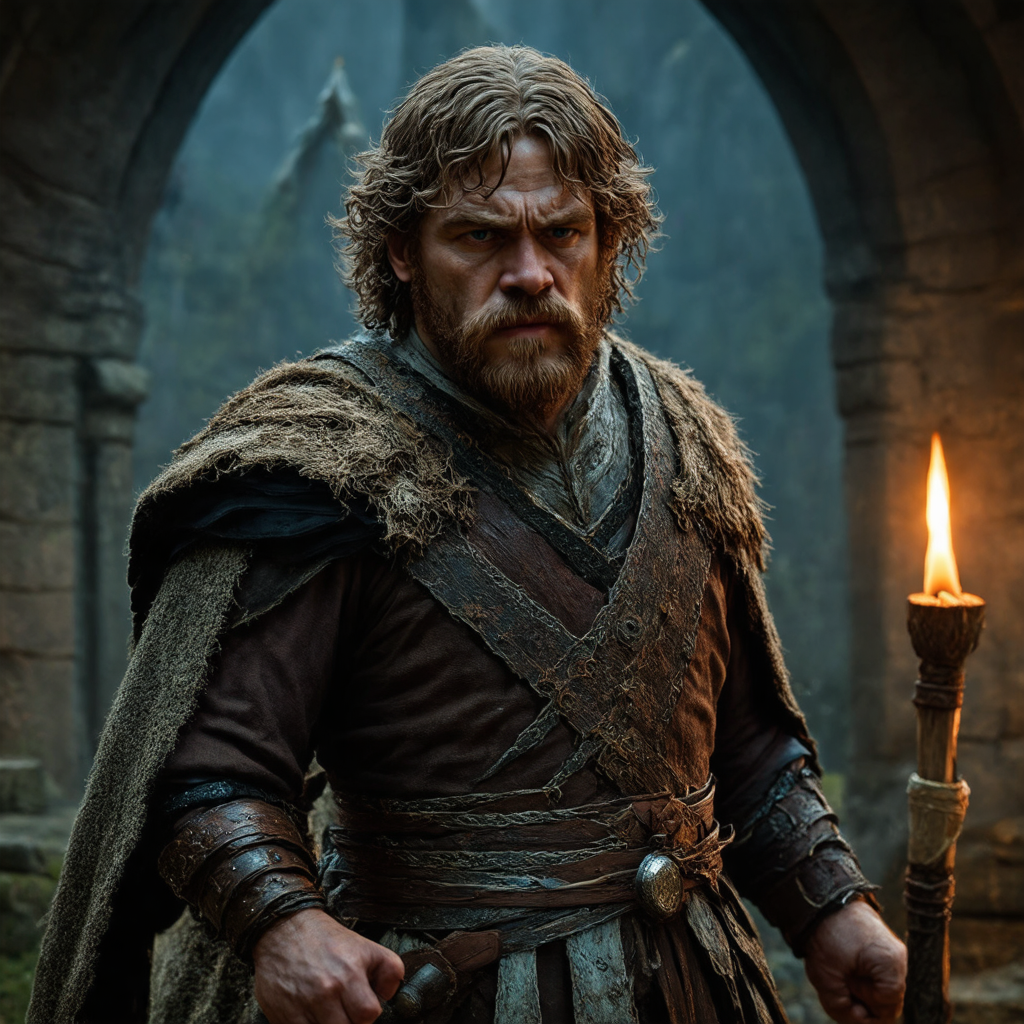

In [ ]:
result = ask_and_draw('¿Cómo muere Ned Stark?', seed=7)
print(result['answer'])
print('PROMPT:', result['prompt'])
result['image']
